In [38]:
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [5]:
network_sizes = [ (2, 36, 6), (3, 36, 36, 6), (3, 36, 6, 6), (4, 36, 36, 6, 6), (4, 36, 36, 36, 6), (5, 36, 36, 36, 6, 6) ]
regularisations = [ 0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 10.0]

In [12]:
trained_networks = {}
for network_size, reg in product(network_sizes, regularisations):
    no_layers = network_size[0]
    nodes_per_layer = list( network_size[1:] )
    trained_network_data = "NN[{}]_reg={}.json".format(",".join([str(x) for x in nodes_per_layer]), reg)
    with open("trained_networks/"+trained_network_data, "r") as f:
        trained_networks[(network_size, reg)] = json.load(f)

In [26]:
#To get trained network of 2 layers, with neurons 36, 6 and regularisation 0.05
def access_trainednetwork(no_layers, nodes_per_layer, regularisation):
    arg1 = tuple( [no_layers] + nodes_per_layer )
    arg2 = regularisation
    return trained_networks[ (arg1, arg2) ]

no_layers = 2
nodes_per_layer = [36, 6]
reg = 0.05
network1 = access_trainednetwork(no_layers=no_layers, nodes_per_layer=nodes_per_layer, regularisation=reg)

""" From training script, this is the order of values:
training_data = [
        list(opt_result.x),
        opt_result.fun,
        [ list(res.x) for res in opt_hist ],
        [res.fun for res in opt_hist],
        ] 
"""
#E.g.
trained_weights = np.array( network1[0] )
training_error = network1[1]
intermediate_weights = network1[2]
intermediate_errors = network1[3]

In [44]:
from train_neural_network import flatten_weights, reshape_weights, forward_pass
from train_neural_network import cost as cost_network
from train_neural_network import backpropagated_gradient as gradient

In [31]:
#Check loaded functions and loaded values agree on trainin set
network1_weights = reshape_weights( trained_weights, nodes_per_layer )
x_train = np.loadtxt("datasets/training_x_inputs.csv", delimiter=",")
y_train = np.loadtxt("datasets/training_y_outputs.csv", delimiter=",")
print("Cost calculated: {}".format( cost_network( network1_weights, x=x_train, y=y_train ) ) )
print("Cost loaded: {}".format(training_error) )

Cost calculated: 0.09994991314774349
Cost loaded: 0.09994991314774349


In [34]:
#Now check error on validation set
x_valid = np.loadtxt("datasets/validation_x_inputs.csv", delimiter=",")
y_valid = np.loadtxt("datasets/validation_y_outputs.csv", delimiter=",")
print("Cost calculated: {}".format( cost_network( network1_weights, x=x_valid, y=y_valid ) ) )

Cost calculated: 0.09976470236687207


In [69]:
#Calculate validation loss per intermediate step:
def get_training_validation_loss(no_layers, nodes_per_layer, reg, x_valid, y_valid):
    network = access_trainednetwork(no_layers=no_layers, nodes_per_layer=nodes_per_layer, regularisation=reg)
    intermediate_weights = network[2]
    training_loss = network[3]
    validation_loss = []
    for wt in intermediate_weights:
        wt = np.asarray(wt, dtype=np.float128)
        wt = reshape_weights( wt, nodes_per_layer )
        loss = cost_network( wt, x_valid, y_valid )
        validation_loss += [loss]
    return training_loss, validation_loss

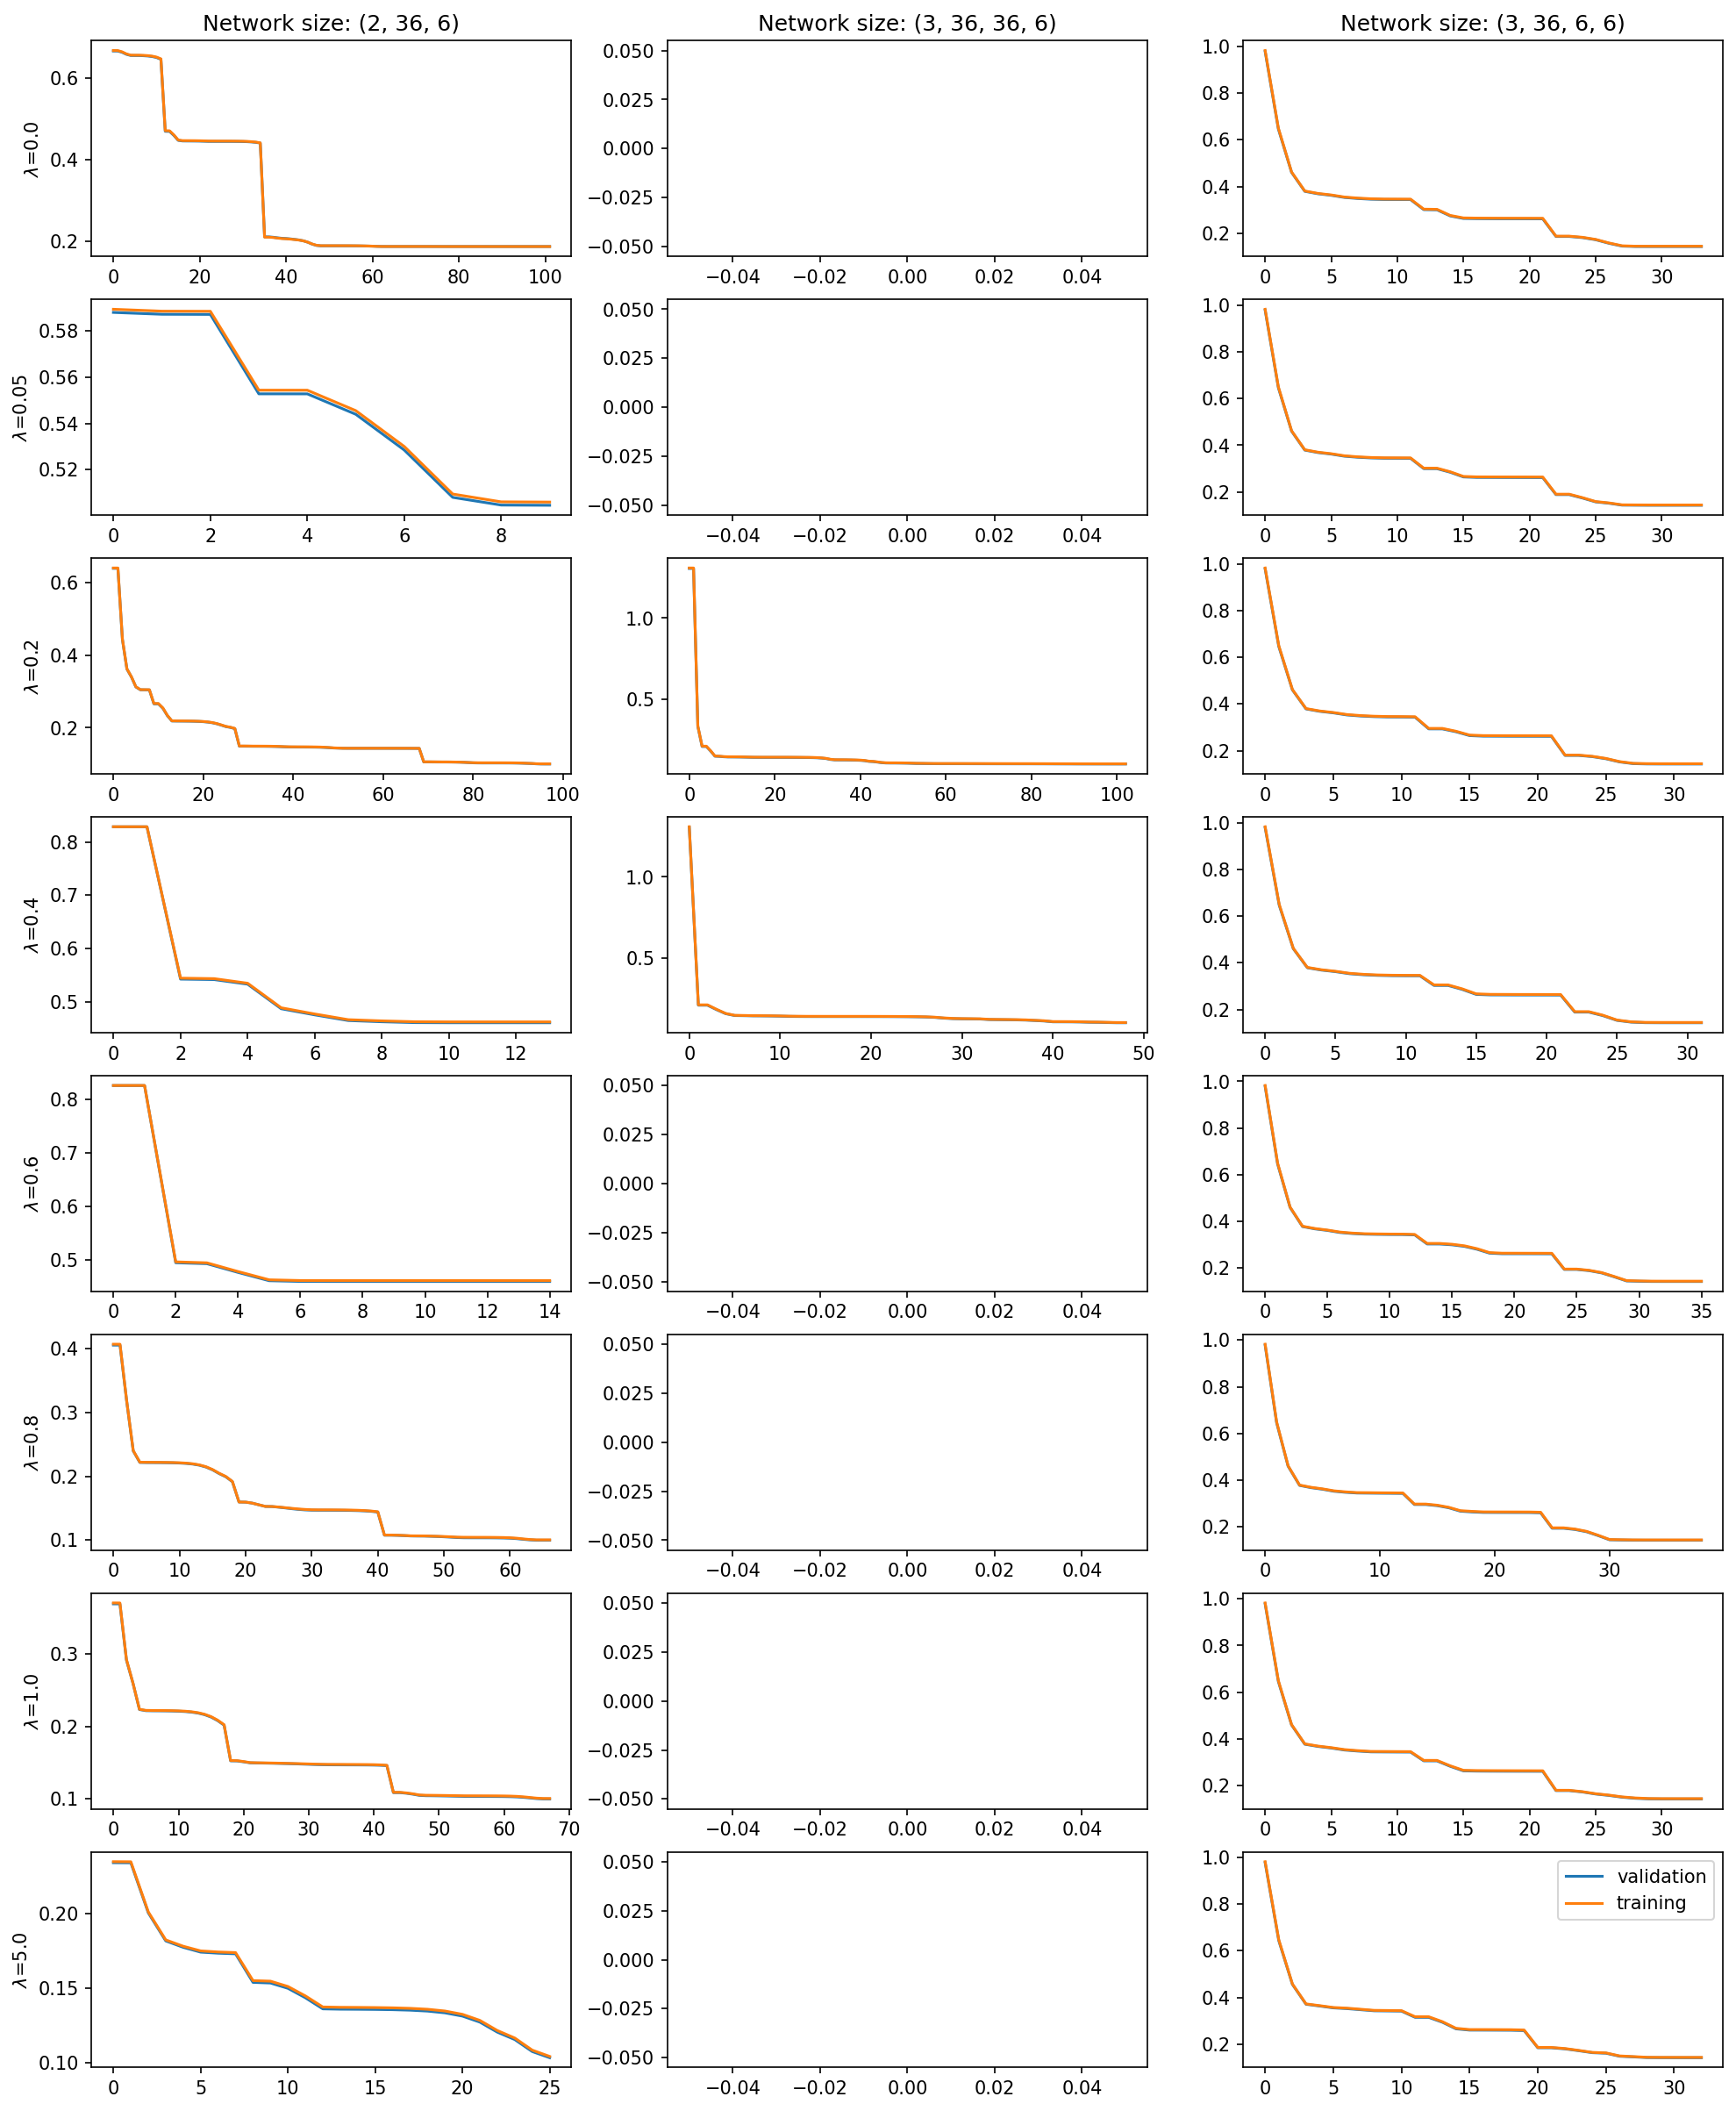

In [73]:
regularisations_to_plot = regularisations[::2]
column_args = network_sizes[:3]
fig, axs = plt.subplots( nrows=len(regularisations_to_plot), ncols=len(column_args), figsize=(16,20), dpi=150 )
for k, reg in enumerate(regularisations_to_plot):
    for j, arg in enumerate(column_args):
        no_layers = arg[0]
        nodes_per_layer = list( arg[1:] )
        training_loss, validation_loss = get_training_validation_loss(no_layers=no_layers, 
                                                                        nodes_per_layer=nodes_per_layer,
                                                                        reg=reg,
                                                                        x_valid=x_valid,
                                                                        y_valid=y_valid
                                                                        )
        axs[k, j].plot( validation_loss, label = "validation" )
        axs[k, j].plot( training_loss, label = "training" )
        if j == 0:
            axs[k, j].set_ylabel("$\lambda$={}".format(reg))
        if k == 0:
            axs[k, j].set_title("Network size: {}".format(arg))
        
axs[k,j].legend()
plt.show()

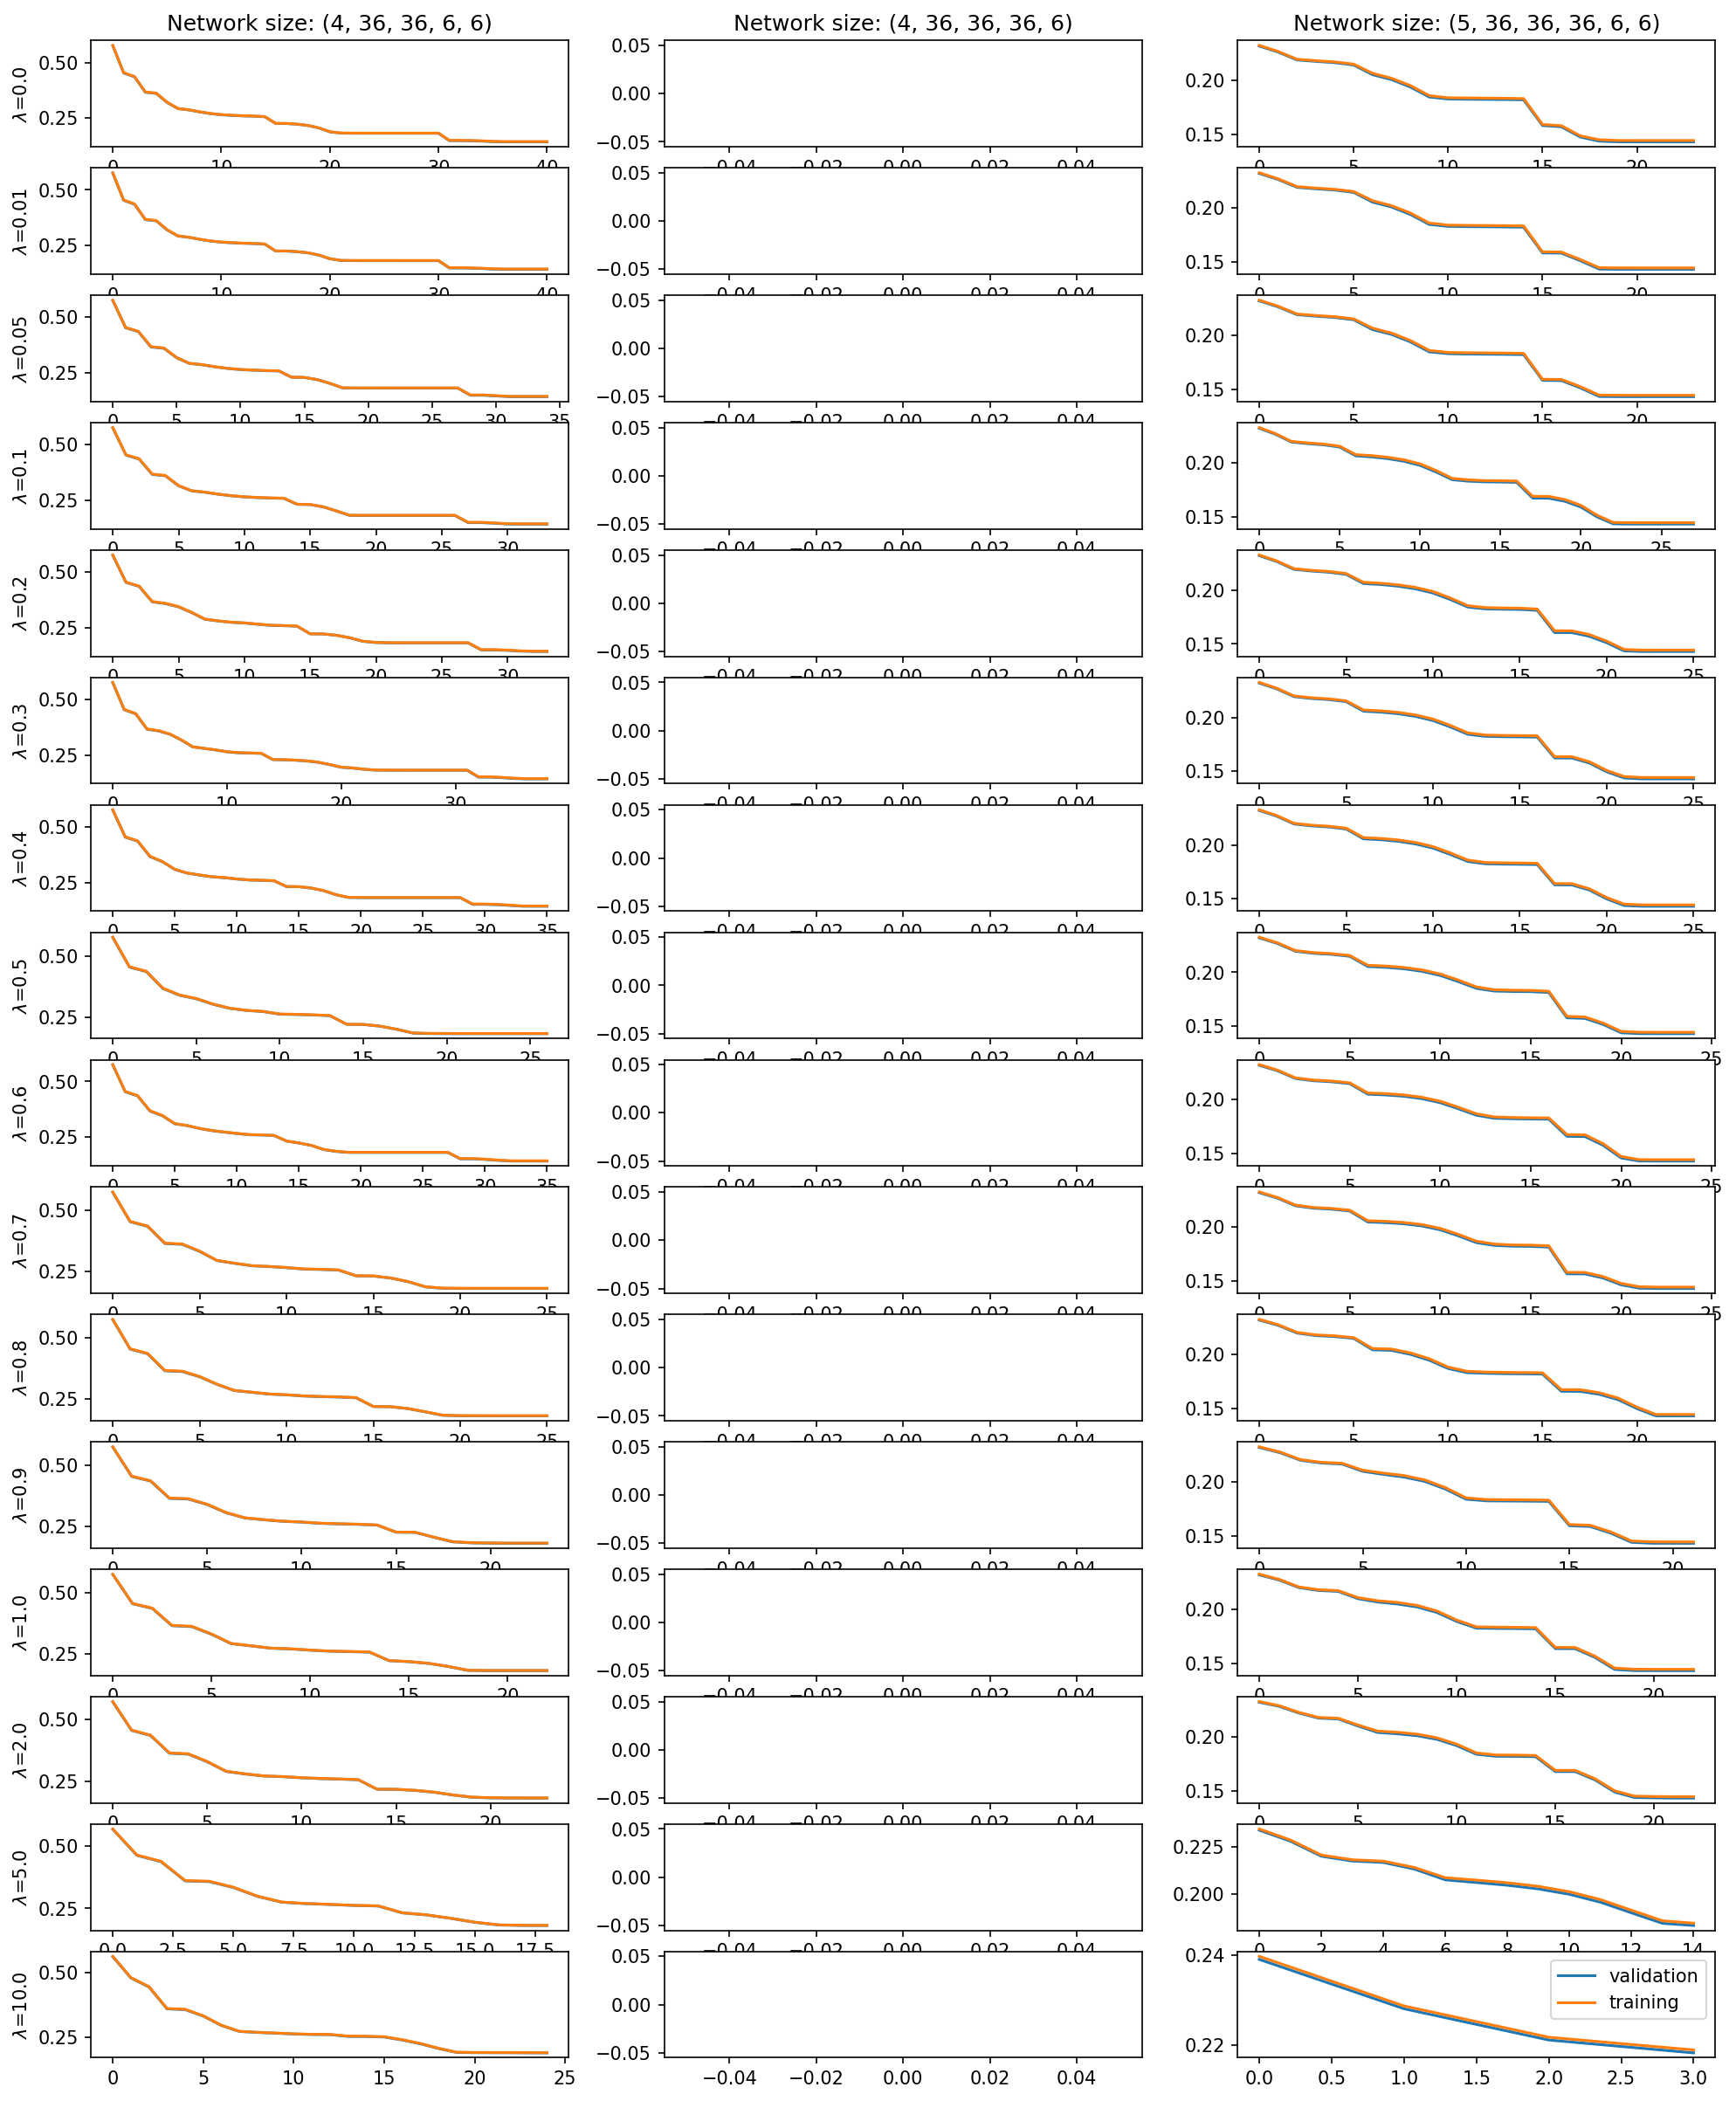

In [84]:
regularisations_to_plot = regularisations
column_args = network_sizes[3:]
fig, axs = plt.subplots( nrows=len(regularisations_to_plot), ncols=len(column_args), figsize=(16,20), dpi=150 )
for k, reg in enumerate(regularisations_to_plot):
    for j, arg in enumerate(column_args):
        no_layers = arg[0]
        nodes_per_layer = list( arg[1:] )
        training_loss, validation_loss = get_training_validation_loss(no_layers=no_layers, 
                                                                        nodes_per_layer=nodes_per_layer,
                                                                        reg=reg,
                                                                        x_valid=x_valid,
                                                                        y_valid=y_valid
                                                                        )
        axs[k, j].plot( validation_loss, label = "validation" )
        axs[k, j].plot( training_loss, label = "training" )
        if j == 0:
            axs[k, j].set_ylabel("$\lambda$={}".format(reg))
        if k == 0:
            axs[k, j].set_title("Network size: {}".format(arg))
        
axs[k,j].legend()
plt.show()

In [83]:
#Which network has the lowest validation error?
best_network = None
best_networksize = None
lowest_error = float('inf')
lowest_reg = None
for (network_size, reg), network_data in trained_networks.items():
    nodes_per_layer = list( network_size[1:] )
    network_weights = np.asarray(network_data[0], dtype=np.float128)
    network_weights = reshape_weights( network_weights, nodes_per_layer )
    network_err = cost_network( network_weights, x_valid, y_valid )
    if network_err < lowest_error:
        lowest_error = network_err
        best_network = network_weights
        best_networksize = network_size
        lowest_reg = reg
print("Best network size: {}".format( best_networksize ) )
print("Best network error on validation set: {}".format( lowest_error ) )

Best network size: (4, 36, 36, 36, 6)
Best network error on validation set: 0.08982401641121095


In [92]:
import networkx as nx
import json
from generate_ising import generate_ising_array
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Statevector, Pauli


def qaoa_circuit(ising_hamiltonian, p=1):
    N = ising_hamiltonian.shape[0]
    gammas = ParameterVector("γ", length=p)
    betas = ParameterVector("β", length=p)
    qaoa_circ = QuantumCircuit(N)
    qaoa_circ.h(range(N))
    for k in range(p):
        add_isingqaoa_layer(qaoa_circ, ising_hamiltonian, gammas[k], betas[k])
    return qaoa_circ, betas, gammas

def add_isingqaoa_layer(qc, ising_hamiltonian, gamma, beta):
    N = ising_hamiltonian.shape[0]
    for i in range(N):
        qc.rz(2*gamma*ising_hamiltonian[i,i], i)
    for i in range(N):
        for j in range(i+1, N):
            qc.cx(i,j)
            qc.rz(2*gamma*ising_hamiltonian[i,j], j)
            qc.cx(i,j)
    qc.rx(2*beta, range(N))

def qiskit_isingop_from_J(J, N):
    ops = []
    for i in range(N):
        for j in range(i+1, N):
            op = ["I"]*N
            op[i] = "Z"
            op[j] = "Z"
            pauli_str = "".join(op)
            if np.abs(J[i,j]) > 1e-6:
                pauli = PauliOp(Pauli( pauli_str[::-1] ), coeff=J[i,j] )
                ops += [pauli]
    op = sum(ops)
    return op

/home/jvillanueva/.local/lib/python3.9/site-packages/qiskit/version.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [183]:
prob_edge = 0.5 #Use prob_edge 0.5, different from training and validation using either 0.3 or 0.7
N = 9
p = 3

def get_rq(J, params, p=3):
    qaoa_qc, _, _ = qaoa_circuit(ising_hamiltonian = J, p=p)
    ising_op = qiskit_isingop_from_J(J, N)
    ising_matrixop = ising_op.to_matrix(massive=False).diagonal().real
    min_E, max_E = ising_matrixop.min(), ising_matrixop.max()
    def qaoa_expectation( params ):
        sv = Statevector( qaoa_qc.assign_parameters(params) ).data
        return np.dot( np.conj(sv), ising_matrixop * sv).real
    exp = qaoa_expectation(params)
    return (max_E - exp) / (max_E - min_E)

In [165]:
xmins = np.loadtxt("datasets/xmins.csv", delimiter=",")
xminmaxrange = np.loadtxt("datasets/xminmaxrange.csv", delimiter=",")
ymins = np.loadtxt("datasets/ymins.csv", delimiter=",")
yminmaxrange = np.loadtxt("datasets/yminmaxrange.csv", delimiter=",")

In [178]:
def predict_angles( J_s ):
    x_inputs = np.zeros( (36, len(J_s)) )
    for s in range(len(J_s)):
        J = J_s[s]
        x = J[ np.triu_indices(N, k=1) ]
        x_inputs[:, s] = x
    #Normalise x:
    xmins_stacked = np.broadcast_to(xmins, (len(J_s),)+xmins.shape).T
    xminmaxrange_stacked = np.broadcast_to(xminmaxrange, (len(J_s),)+xminmaxrange.shape).T
    ymins_stacked = np.broadcast_to(ymins, (len(J_s),)+ymins.shape).T
    yminmaxrange_stacked = np.broadcast_to(yminmaxrange, (len(J_s),)+yminmaxrange.shape).T
    x_inputs -= xmins_stacked
    x_inputs /= xminmaxrange_stacked
    
    #Forward pass to network and denormalise y
    y = forward_pass(best_network, x=x_inputs)
    y *= yminmaxrange_stacked
    y += ymins_stacked

    #Turn gammas back into negative values:
    y[3:, :] *= -1

    return y

In [185]:
J_s = [ None for _ in range(8) ] #6 ising instances
J_s[0], _ = generate_ising_array(N, prob_edge=0.3, weighted=True, seed=65414)
J_s[1], _ = generate_ising_array(N, prob_edge=0.5, weighted=True, seed=11584)
J_s[2], _ = generate_ising_array(N, prob_edge=0.7, weighted=True, seed=19721)
J_s[3], _ = generate_ising_array(N, prob_edge=0.3, weighted=False, seed=566)
J_s[4], _ = generate_ising_array(N, prob_edge=0.5, weighted=False, seed=623)
J_s[5], _ = generate_ising_array(N, prob_edge=0.7, weighted=False, seed=66889)
J_s[6], _ = generate_ising_array(N, prob_edge=0.9, weighted=True, seed=414)
J_s[7], _ = generate_ising_array(N, prob_edge=0.1, weighted=True, seed=641)

In [186]:
angles = predict_angles(J_s)

In [187]:
print("Predicted angles for these ising instances:")
for s in range(8):
    print("{}: ".format(s), angles[:, s])

Predicted angles for these ising instances:
0:  [ 0.55878655  0.37572917  0.20731429 -0.21492873 -0.39860897 -0.44499805]
1:  [ 0.55931697  0.37596138  0.20735685 -0.21517824 -0.39886166 -0.44525146]
2:  [ 0.55139817  0.3717719   0.20650753 -0.2106947  -0.3933062  -0.43999017]
3:  [ 0.54258535  0.36706385  0.20552608 -0.20579809 -0.38689433 -0.43399758]
4:  [ 0.49202796  0.34146685  0.19992684 -0.18118894 -0.35188188 -0.40233237]
5:  [ 0.41237465  0.29799409  0.18972241 -0.14869852 -0.29788456 -0.3507722 ]
6:  [ 0.56257614  0.3777395   0.20769639 -0.21705358 -0.40105932 -0.44746986]
7:  [ 0.5558773   0.37415045  0.20700202 -0.21325661 -0.3965651  -0.44301799]


In [188]:
print("R_q for these ising instances using predicted angles:")
for s in range(8):
    r_q = get_rq(J_s[s], params=angles[:, s])
    print("{}: ".format(s), r_q)

R_q for these ising instances using predicted angles:
0:  0.8006408616951086
1:  0.8222617082285179
2:  0.854090425086296
3:  0.8564545507347654
4:  0.9100008108665285
5:  0.9256831156882752
6:  0.7791169904053634
7:  0.9127697960402826
